# pyspark&&hudi quickstart
## 1.hudi插入数据

In [8]:
#定义表名
tableName = "hudi_trips_cow"
#定义存储路径
basePath = "file:///opt/data/hudi_trips_cow"

#hudi的工具类：QuickstartUtils，用来生成册书数据
dataGen = sc._jvm.org.apache.hudi.QuickstartUtils.DataGenerator()

In [9]:
# 生成了10条数据
inserts = sc._jvm.org.apache.hudi.QuickstartUtils.convertToStringList(dataGen.generateInserts(10))
# 转化为dataframe，数据被划分为两个分区
df = spark.read.json(spark.sparkContext.parallelize(inserts, 2))
df.show()

+-------------------+-------------------+----------+-------------------+-------------------+------------------+--------------------+---------+---+--------------------+
|          begin_lat|          begin_lon|    driver|            end_lat|            end_lon|              fare|       partitionpath|    rider| ts|                uuid|
+-------------------+-------------------+----------+-------------------+-------------------+------------------+--------------------+---------+---+--------------------+
| 0.4726905879569653|0.46157858450465483|driver-213|  0.754803407008858| 0.9671159942018241|34.158284716382845|americas/brazil/s...|rider-213|0.0|4c24b4a1-0168-427...|
| 0.6100070562136587| 0.8779402295427752|driver-213| 0.3407870505929602| 0.5030798142293655|  43.4923811219014|americas/brazil/s...|rider-213|0.0|14657a04-2488-440...|
| 0.5731835407930634| 0.4923479652912024|driver-213|0.08988581780930216|0.42520899698713666| 64.27696295884016|americas/united_s...|rider-213|0.0|3dad2536-7f33-

In [10]:
# hudi操作配置，
hudi_options = {
  'hoodie.table.name': tableName,
  'hoodie.datasource.write.recordkey.field': 'uuid',
  'hoodie.datasource.write.partitionpath.field': 'partitionpath',
  'hoodie.datasource.write.table.name': tableName,
  'hoodie.datasource.write.operation': 'insert',
  'hoodie.datasource.write.precombine.field': 'ts',
  'hoodie.upsert.shuffle.parallelism': 2, 
  'hoodie.insert.shuffle.parallelism': 2
}
# hoodie.datasource.write.precombine.field, 默认值：ts 
# 实际写入之前在preCombining中使用的字段。 当两个记录具有相同的键值(recordkey)时，我们将使用Object.compareTo(..)从precombine字段中选择一个值最大的记录。

#hoodie.datasource.write.recordkey.field, 默认值：uuid 
#记录键字段。用作HoodieKey中recordKey部分的值。 实际值将通过在字段值上调用.toString()来获得。可以使用点符号指定嵌套字段，例如：a.b.c

#属性：hoodie.datasource.write.partitionpath.field, 默认值：partitionpath 
#分区路径字段。用作HoodieKey中partitionPath部分的值。 通过调用.toString()获得实际的值

#属性：hoodie.insert.shuffle.parallelism, hoodie.upsert.shuffle.parallelism
#最初导入数据后，此并行度将控制用于读取输入记录的初始并行度。 确保此值足够高，例如：1个分区用于1 GB的输入数据

#属性：hoodie.datasource.write.operation, 默认值：upsert
#是否为写操作进行插入更新、插入或批量插入。使用bulkinsert将新数据加载到表中，之后使用upsert或insert。 
#批量插入使用基于磁盘的写入路径来扩展以加载大量输入，而无需对其进行缓存。
#如果是大量数据使用bulkinsert

# 只有第一次创建表才使用，overwrite，其他情况都应该用append
df.write.format("hudi"). \
  options(**hudi_options). \
  mode("overwrite"). \
  save(basePath)


表初始化化后的文件结构
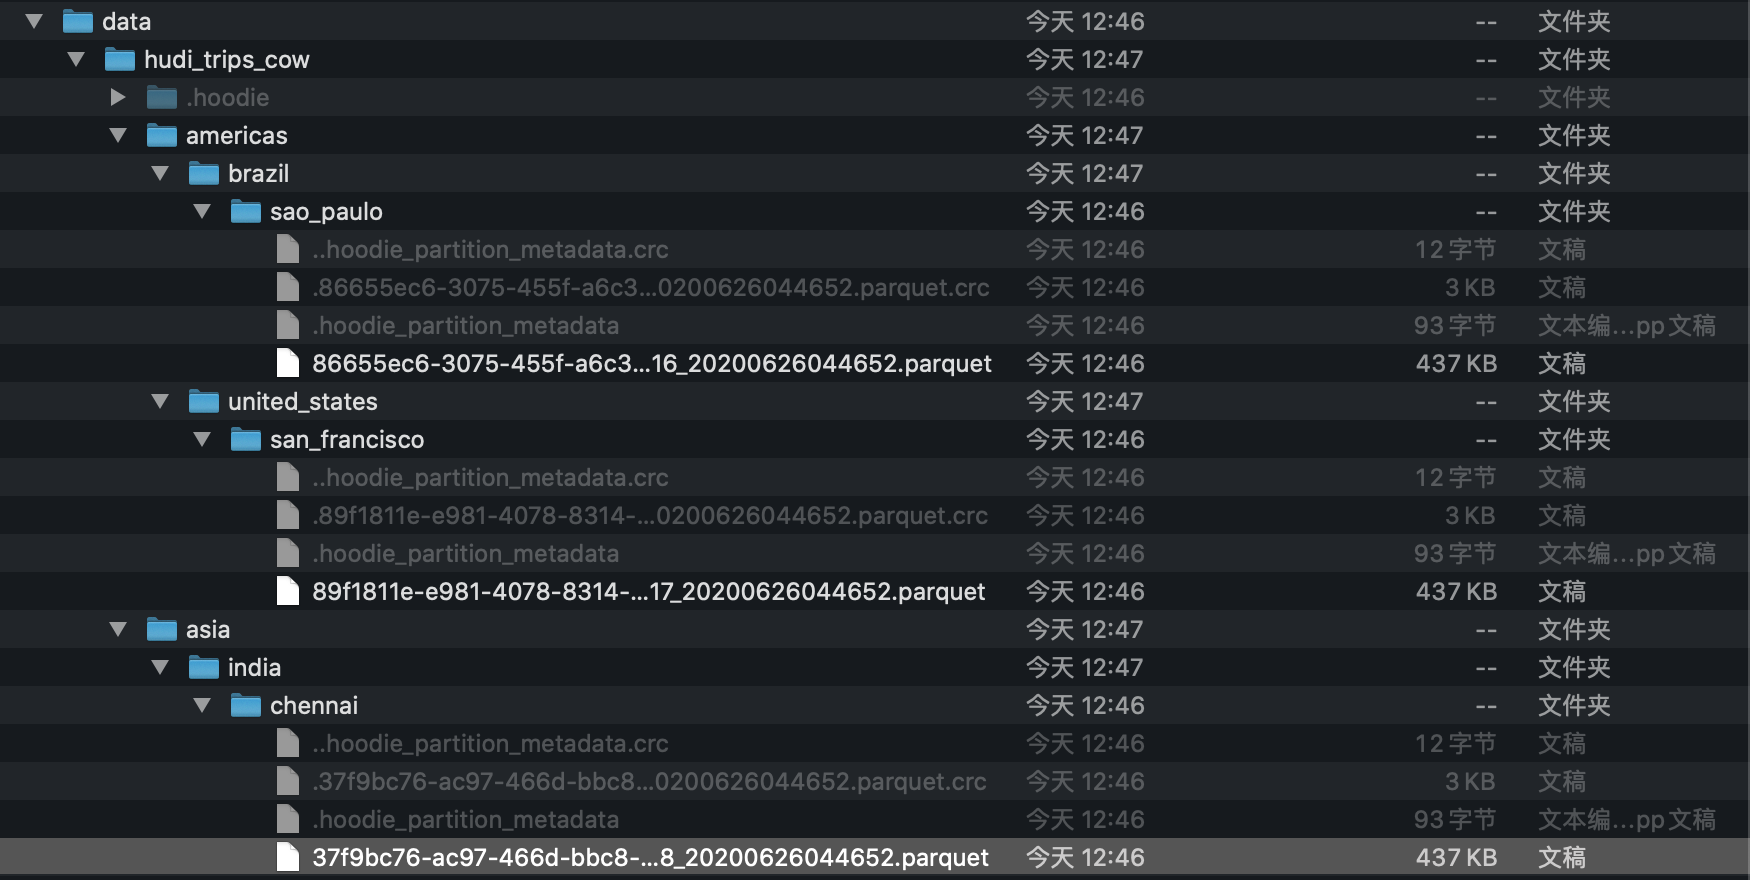

## 2.查询数据
1. 将hudi表结构目录，使用hudi格式读取成dataframe
2. 定义一个临时表
3. 在临时表上执行各种sparksql

In [11]:
# 读取数据例子，注意load路径的写法
tripsSnapshotDF = spark. \
  read. \
  format("hudi"). \
  load(basePath + "/*/*/*/*")
# load(basePath) use "/partitionKey=partitionValue" folder structure for Spark auto partition discovery
#创建一个视图，都是spark sql的标准操作
tripsSnapshotDF.createOrReplaceTempView("hudi_trips_snapshot")

In [14]:
# 获取数据数量
count = tripsSnapshotDF.count()

print("数据量：" , count)

spark.sql("select count(1) from  hudi_trips_snapshot").show()


数据量： 10
+--------+
|count(1)|
+--------+
|      10|
+--------+



In [16]:
new_df = tripsSnapshotDF.select(["_hoodie_commit_time","_hoodie_record_key","_hoodie_partition_path","rider","driver","fare"])

new_df.show()

spark.sql("select _hoodie_commit_time, _hoodie_record_key, _hoodie_partition_path, rider, driver, fare from  hudi_trips_snapshot").show()

+-------------------+--------------------+----------------------+---------+----------+------------------+
|_hoodie_commit_time|  _hoodie_record_key|_hoodie_partition_path|    rider|    driver|              fare|
+-------------------+--------------------+----------------------+---------+----------+------------------+
|     20200626130414|3dad2536-7f33-418...|  americas/united_s...|rider-213|driver-213| 64.27696295884016|
|     20200626130414|d51ffec5-60ac-489...|  americas/united_s...|rider-213|driver-213| 93.56018115236618|
|     20200626130414|47bc52aa-dd97-46d...|  americas/united_s...|rider-213|driver-213|19.179139106643607|
|     20200626130414|5e83112b-49a9-414...|  americas/united_s...|rider-213|driver-213| 33.92216483948643|
|     20200626130414|a5547435-6566-47d...|  americas/united_s...|rider-213|driver-213| 27.79478688582596|
|     20200626130414|4c24b4a1-0168-427...|  americas/brazil/s...|rider-213|driver-213|34.158284716382845|
|     20200626130414|14657a04-2488-440...|  am

In [18]:
tripsSnapshotDF.select(["_hoodie_commit_time","fare","begin_lon","begin_lat","ts"]).where("fare > 20.0").show()

spark.sql("select _hoodie_commit_time , fare, begin_lon, begin_lat, ts from  hudi_trips_snapshot where fare > 20.0").show()

+-------------------+------------------+-------------------+-------------------+---+
|_hoodie_commit_time|              fare|          begin_lon|          begin_lat| ts|
+-------------------+------------------+-------------------+-------------------+---+
|     20200626130414| 64.27696295884016| 0.4923479652912024| 0.5731835407930634|0.0|
|     20200626130414| 93.56018115236618|0.14285051259466197|0.21624150367601136|0.0|
|     20200626130414| 33.92216483948643| 0.9694586417848392| 0.1856488085068272|0.0|
|     20200626130414| 27.79478688582596| 0.6273212202489661|0.11488393157088261|0.0|
|     20200626130414|34.158284716382845|0.46157858450465483| 0.4726905879569653|0.0|
|     20200626130414|  43.4923811219014| 0.8779402295427752| 0.6100070562136587|0.0|
|     20200626130414| 66.62084366450246|0.03844104444445928| 0.0750588760043035|0.0|
|     20200626130414| 41.06290929046368| 0.8192868687714224|  0.651058505660742|0.0|
+-------------------+------------------+-------------------+-----

# 3.更新数据

更新的数据集和表数据uuid是完全重复的。

In [28]:
 # 新生成10调数据，注意wirte的模式是append，追加
updates = sc._jvm.org.apache.hudi.QuickstartUtils.convertToStringList(dataGen.generateUpdates(10))
df.show()


df0 = df.select(["uuid"]).orderBy("uuid")
df0.show()
print("这是表里已经有的数据")
df1 = spark.sql("select uuid from hudi_trips_snapshot order by uuid").show()

# 将更相信的数据，并行化为两个分区
df_updates = spark.read.json(spark.sparkContext.parallelize(updates, 2))
print("这是准备更新的数据")
df_updates.select(["uuid","ts"]).orderBy("uuid").show()
# 更新数据10条，其中有三条uuid是重复的。7条不重复uuid全部已经在表里存在

+-------------------+-------------------+----------+-------------------+-------------------+------------------+--------------------+---------+---+--------------------+
|          begin_lat|          begin_lon|    driver|            end_lat|            end_lon|              fare|       partitionpath|    rider| ts|                uuid|
+-------------------+-------------------+----------+-------------------+-------------------+------------------+--------------------+---------+---+--------------------+
| 0.4726905879569653|0.46157858450465483|driver-213|  0.754803407008858| 0.9671159942018241|34.158284716382845|americas/brazil/s...|rider-213|0.0|4c24b4a1-0168-427...|
| 0.6100070562136587| 0.8779402295427752|driver-213| 0.3407870505929602| 0.5030798142293655|  43.4923811219014|americas/brazil/s...|rider-213|0.0|14657a04-2488-440...|
| 0.5731835407930634| 0.4923479652912024|driver-213|0.08988581780930216|0.42520899698713666| 64.27696295884016|americas/united_s...|rider-213|0.0|3dad2536-7f33-

In [29]:
# 注意这里的 mode用的append
df.write.format("hudi"). \
  options(**hudi_options). \
  mode("append"). \
  save(basePath)

更新后的表目录结构
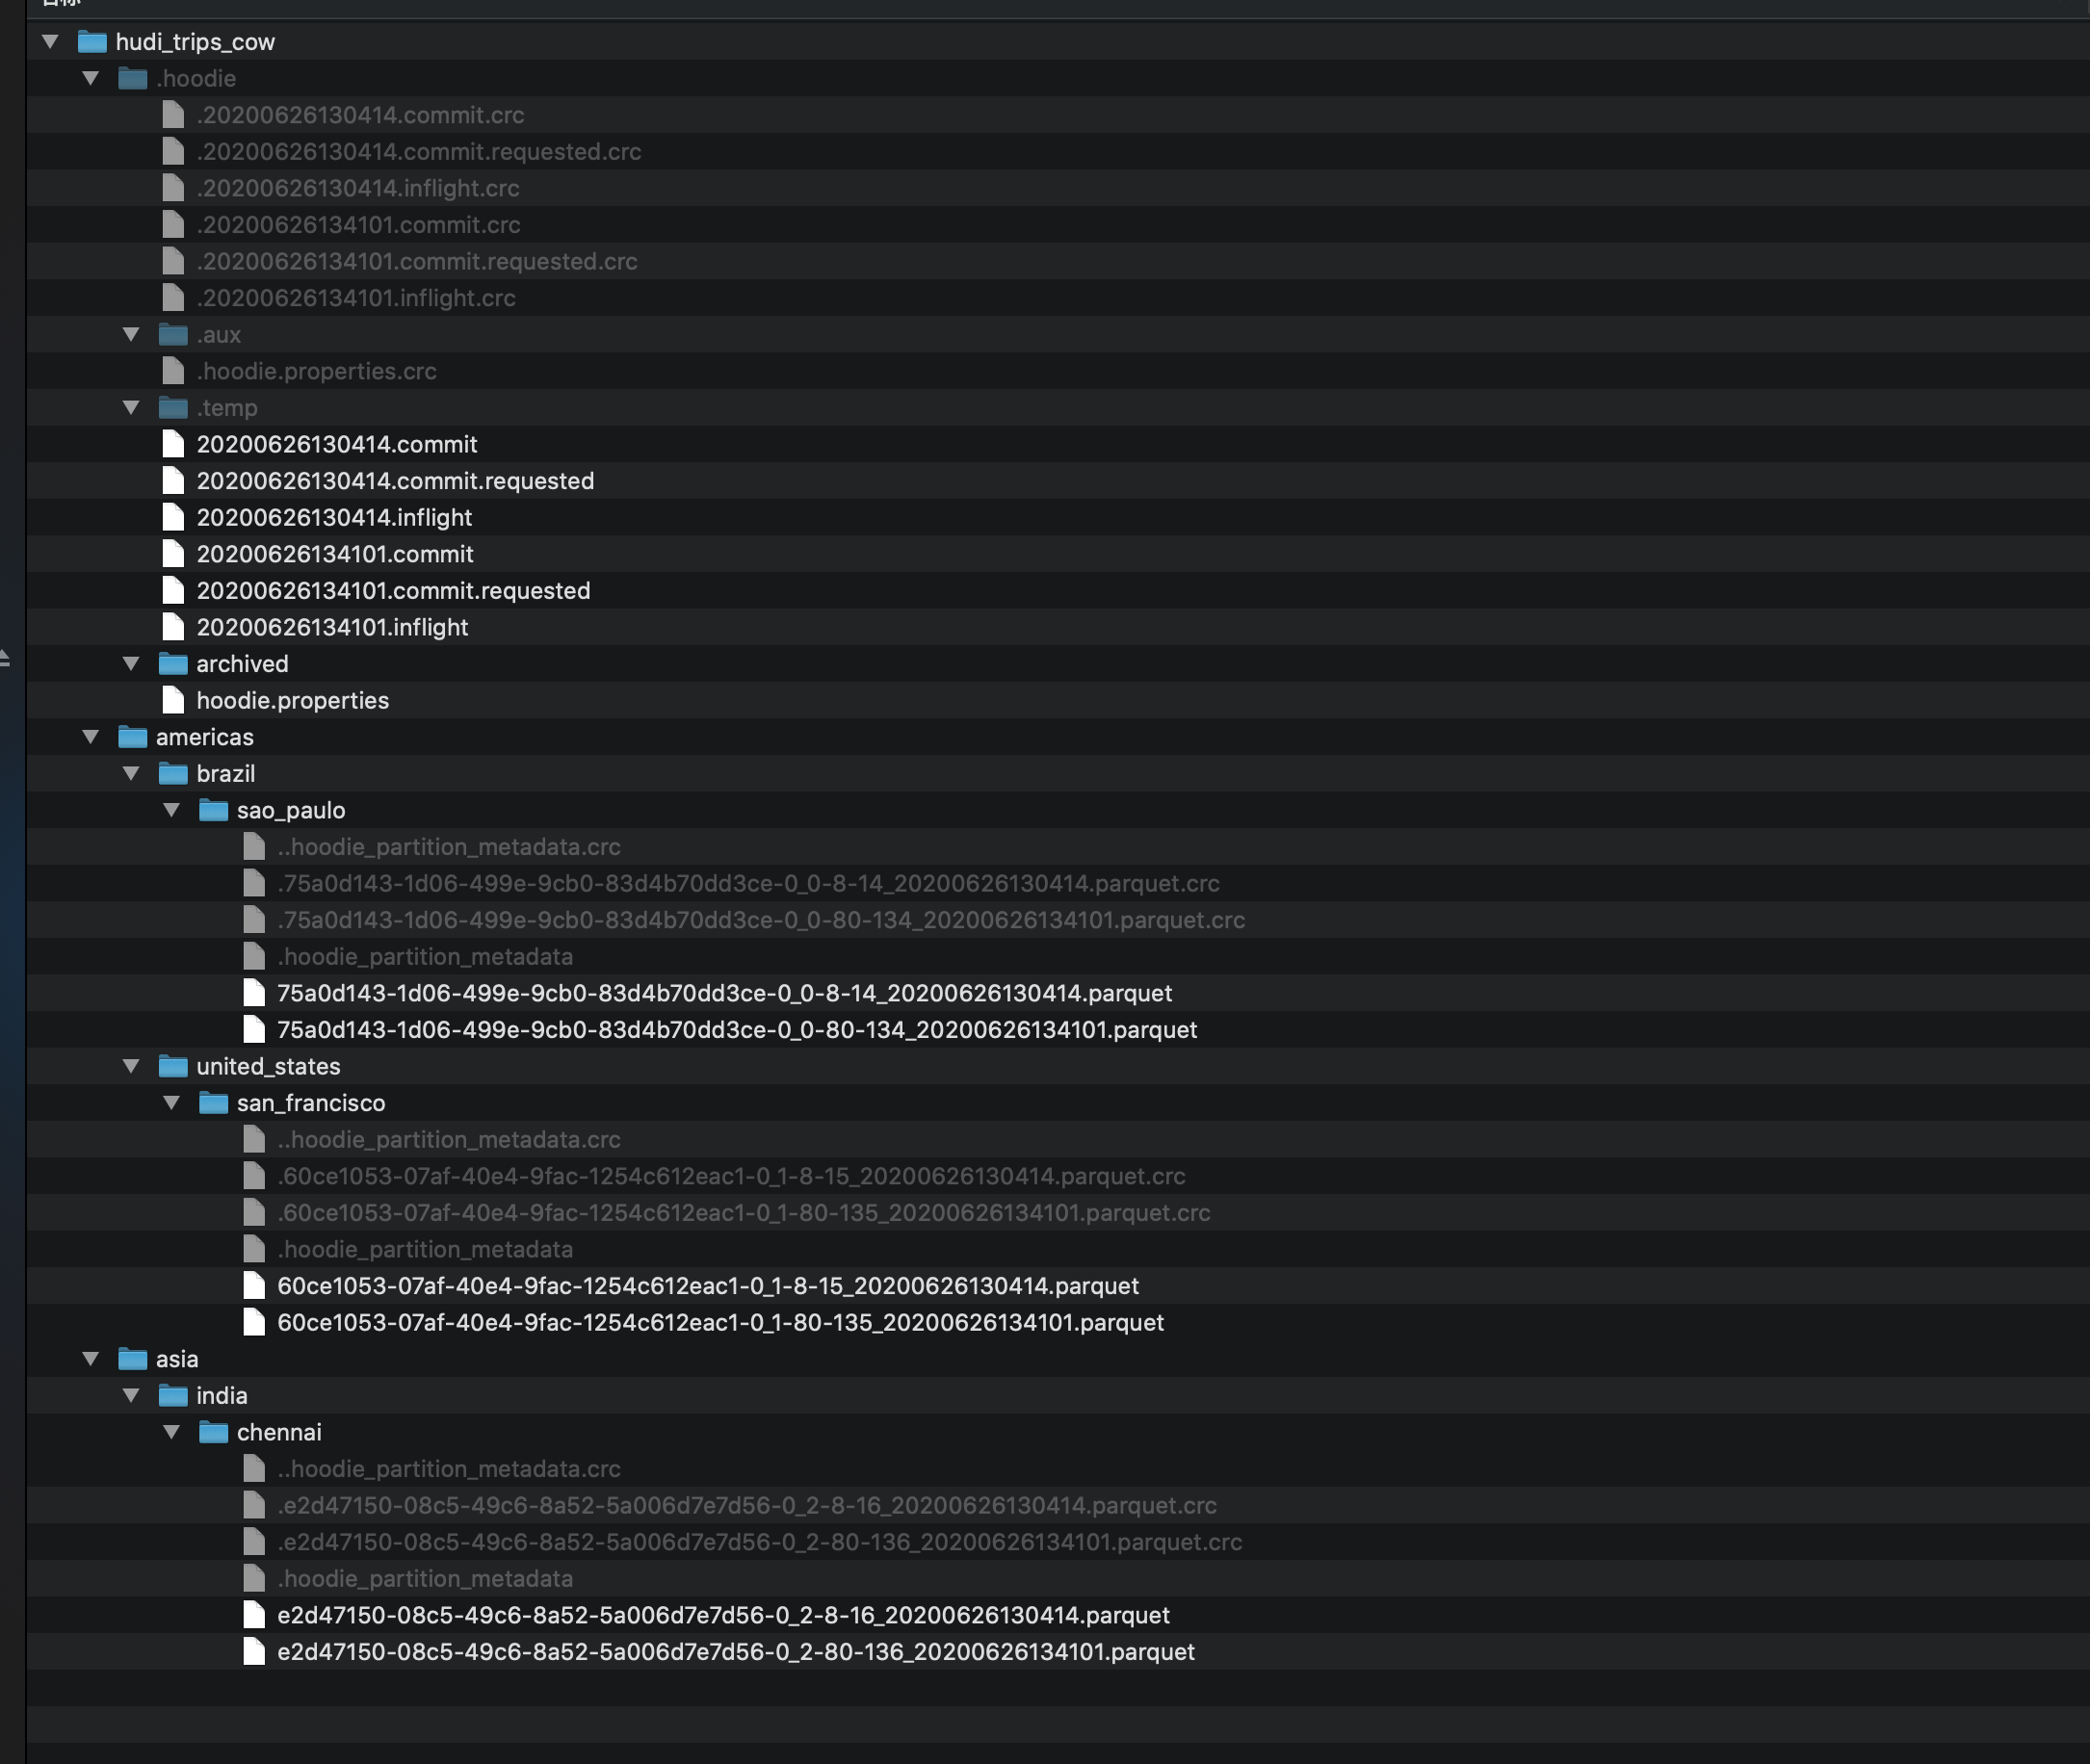

In [12]:
#使用原来的视图查询还是10条
spark.sql("select _hoodie_commit_time , fare, begin_lon, begin_lat, ts from  hudi_trips_snapshot where fare > 20.0").show()

+-------------------+------------------+-------------------+-------------------+---+
|_hoodie_commit_time|              fare|          begin_lon|          begin_lat| ts|
+-------------------+------------------+-------------------+-------------------+---+
|     20200626052507| 64.27696295884016| 0.4923479652912024| 0.5731835407930634|0.0|
|     20200626052507| 93.56018115236618|0.14285051259466197|0.21624150367601136|0.0|
|     20200626052507| 33.92216483948643| 0.9694586417848392| 0.1856488085068272|0.0|
|     20200626052507| 27.79478688582596| 0.6273212202489661|0.11488393157088261|0.0|
|     20200626052507|34.158284716382845|0.46157858450465483| 0.4726905879569653|0.0|
|     20200626052507|  43.4923811219014| 0.8779402295427752| 0.6100070562136587|0.0|
|     20200626052507| 66.62084366450246|0.03844104444445928| 0.0750588760043035|0.0|
|     20200626052507| 41.06290929046368| 0.8192868687714224|  0.651058505660742|0.0|
+-------------------+------------------+-------------------+-----

In [30]:
# 要想获取新数据，需要重加载一下视图
spark. \
  read. \
  format("hudi"). \
  load(basePath + "/*/*/*/*"). \
  createOrReplaceTempView("hudi_trips_snapshot")

In [31]:
#重加载后查询
spark.sql("select _hoodie_commit_time , fare, begin_lon, begin_lat, ts from  hudi_trips_snapshot where fare > 20.0 order by _hoodie_commit_time").show()

+-------------------+------------------+-------------------+-------------------+---+
|_hoodie_commit_time|              fare|          begin_lon|          begin_lat| ts|
+-------------------+------------------+-------------------+-------------------+---+
|     20200626134101|34.158284716382845|0.46157858450465483| 0.4726905879569653|0.0|
|     20200626134101|  43.4923811219014| 0.8779402295427752| 0.6100070562136587|0.0|
|     20200626134101| 66.62084366450246|0.03844104444445928| 0.0750588760043035|0.0|
|     20200626134101| 41.06290929046368| 0.8192868687714224|  0.651058505660742|0.0|
|     20200626134101| 64.27696295884016| 0.4923479652912024| 0.5731835407930634|0.0|
|     20200626134101| 93.56018115236618|0.14285051259466197|0.21624150367601136|0.0|
|     20200626134101| 33.92216483948643| 0.9694586417848392| 0.1856488085068272|0.0|
|     20200626134101| 27.79478688582596| 0.6273212202489661|0.11488393157088261|0.0|
+-------------------+------------------+-------------------+-----

# 4.查询增量数据

In [33]:
commits = list(map(lambda row: row[0], spark.sql("select distinct(_hoodie_commit_time) as commitTime from  hudi_trips_snapshot order by commitTime").limit(50).collect()))
beginTime = commits[len(commits) - 2] # commit time we are interested in
beginTime = '20200626052507'
print("开始时间是:", beginTime)
# 增量查询，并设置开始时间
incremental_read_options = {
  'hoodie.datasource.query.type': 'incremental',
  'hoodie.datasource.read.begin.instanttime': beginTime,
}

tripsIncrementalDF = spark.read.format("hudi"). \
  options(**incremental_read_options). \
  load(basePath)
tripsIncrementalDF.createOrReplaceTempView("hudi_trips_incremental")

spark.sql("select `_hoodie_commit_time`, fare, begin_lon, begin_lat, ts from  hudi_trips_incremental where fare > 20.0").show()

开始时间是: 20200626052507
+-------------------+------------------+-------------------+-------------------+---+
|_hoodie_commit_time|              fare|          begin_lon|          begin_lat| ts|
+-------------------+------------------+-------------------+-------------------+---+
|     20200626134101| 64.27696295884016| 0.4923479652912024| 0.5731835407930634|0.0|
|     20200626134101| 93.56018115236618|0.14285051259466197|0.21624150367601136|0.0|
|     20200626134101| 33.92216483948643| 0.9694586417848392| 0.1856488085068272|0.0|
|     20200626134101| 27.79478688582596| 0.6273212202489661|0.11488393157088261|0.0|
|     20200626134101|34.158284716382845|0.46157858450465483| 0.4726905879569653|0.0|
|     20200626134101|  43.4923811219014| 0.8779402295427752| 0.6100070562136587|0.0|
|     20200626134101| 66.62084366450246|0.03844104444445928| 0.0750588760043035|0.0|
|     20200626134101| 41.06290929046368| 0.8192868687714224|  0.651058505660742|0.0|
+-------------------+------------------+---

# 5.时间段查询
和增量查询方法一致，增加了一个结束时间

In [36]:
# pyspark
beginTime = "000" # Represents all commits > this time.
endTime = commits[len(commits) - 2]

# query point in time data
point_in_time_read_options = {
  'hoodie.datasource.query.type': 'incremental',
  'hoodie.datasource.read.end.instanttime': endTime,
  'hoodie.datasource.read.begin.instanttime': beginTime
}

tripsPointInTimeDF = spark.read.format("hudi"). \
  options(**point_in_time_read_options). \
  load(basePath)
print("开始时间:" , beginTime, "\t结束时间：", endTime)
tripsPointInTimeDF.createOrReplaceTempView("hudi_trips_point_in_time")
spark.sql("select `_hoodie_commit_time`, fare, begin_lon, begin_lat, ts from hudi_trips_point_in_time where fare > 20.0").show()

开始时间: 000 	结束时间： 20200626134101
+-------------------+------------------+-------------------+-------------------+---+
|_hoodie_commit_time|              fare|          begin_lon|          begin_lat| ts|
+-------------------+------------------+-------------------+-------------------+---+
|     20200626134101| 64.27696295884016| 0.4923479652912024| 0.5731835407930634|0.0|
|     20200626134101| 93.56018115236618|0.14285051259466197|0.21624150367601136|0.0|
|     20200626134101| 33.92216483948643| 0.9694586417848392| 0.1856488085068272|0.0|
|     20200626134101| 27.79478688582596| 0.6273212202489661|0.11488393157088261|0.0|
|     20200626134101|34.158284716382845|0.46157858450465483| 0.4726905879569653|0.0|
|     20200626134101|  43.4923811219014| 0.8779402295427752| 0.6100070562136587|0.0|
|     20200626134101| 66.62084366450246|0.03844104444445928| 0.0750588760043035|0.0|
|     20200626134101| 41.06290929046368| 0.8192868687714224|  0.651058505660742|0.0|
+-------------------+------------

# 6. 删除
1. 创建一个dataframe包含，主键（uuid），分区字段（partitionPath）， precombine字段（ts）
2. hoodie.datasource.write.operation，设置为delete
3. 使用df去写目录，write mode使用append

In [38]:
# pyspark
# fetch total records count
count = spark.sql("select uuid, partitionPath from hudi_trips_snapshot").count()
print(count)
# fetch two records to be deleted
ds = spark.sql("select uuid, partitionPath from hudi_trips_snapshot").limit(2)
ds.show()

10
+--------------------+--------------------+
|                uuid|       partitionPath|
+--------------------+--------------------+
|3dad2536-7f33-418...|americas/united_s...|
|d51ffec5-60ac-489...|americas/united_s...|
+--------------------+--------------------+



In [39]:
# issue deletes
hudi_delete_options = {
  'hoodie.table.name': tableName,
  'hoodie.datasource.write.recordkey.field': 'uuid',
  'hoodie.datasource.write.partitionpath.field': 'partitionpath',
  'hoodie.datasource.write.table.name': tableName,
  'hoodie.datasource.write.operation': 'delete',
  'hoodie.datasource.write.precombine.field': 'ts',
  'hoodie.upsert.shuffle.parallelism': 2, 
  'hoodie.insert.shuffle.parallelism': 2
}

from pyspark.sql.functions import lit
deletes = list(map(lambda row: (row[0], row[1]), ds.collect()))
print("准备删除的数据")
print(deletes)
df = spark.sparkContext.parallelize(deletes).toDF(['uuid','partitionpath']).withColumn('ts', lit(0.0))
df.show()
df.write.format("hudi"). \
  options(**hudi_delete_options). \
  mode("append"). \
  save(basePath)

准备删除的数据
[('3dad2536-7f33-4184-ab9e-0fd2f4948c6e', 'americas/united_states/san_francisco'), ('d51ffec5-60ac-489d-bcde-94d576f3652f', 'americas/united_states/san_francisco')]
+--------------------+--------------------+---+
|                uuid|       partitionpath| ts|
+--------------------+--------------------+---+
|3dad2536-7f33-418...|americas/united_s...|0.0|
|d51ffec5-60ac-489...|americas/united_s...|0.0|
+--------------------+--------------------+---+



In [40]:
# run the same read query as above.
roAfterDeleteViewDF = spark. \
  read. \
  format("hudi"). \
  load(basePath + "/*/*/*/*") 
roAfterDeleteViewDF.registerTempTable("hudi_trips_snapshot")
# fetch should return (total - 2) records
result = spark.sql("select uuid, partitionPath from hudi_trips_snapshot")
result.show()
print(result.count())

+--------------------+--------------------+
|                uuid|       partitionPath|
+--------------------+--------------------+
|47bc52aa-dd97-46d...|americas/united_s...|
|5e83112b-49a9-414...|americas/united_s...|
|a5547435-6566-47d...|americas/united_s...|
|4c24b4a1-0168-427...|americas/brazil/s...|
|14657a04-2488-440...|americas/brazil/s...|
|e210af6c-edb2-416...|americas/brazil/s...|
|24ca6908-cb75-4e4...|  asia/india/chennai|
|567e5d3e-a436-4dc...|  asia/india/chennai|
+--------------------+--------------------+

8


还剩8条数据。
删除数据后的表文件目录结构：
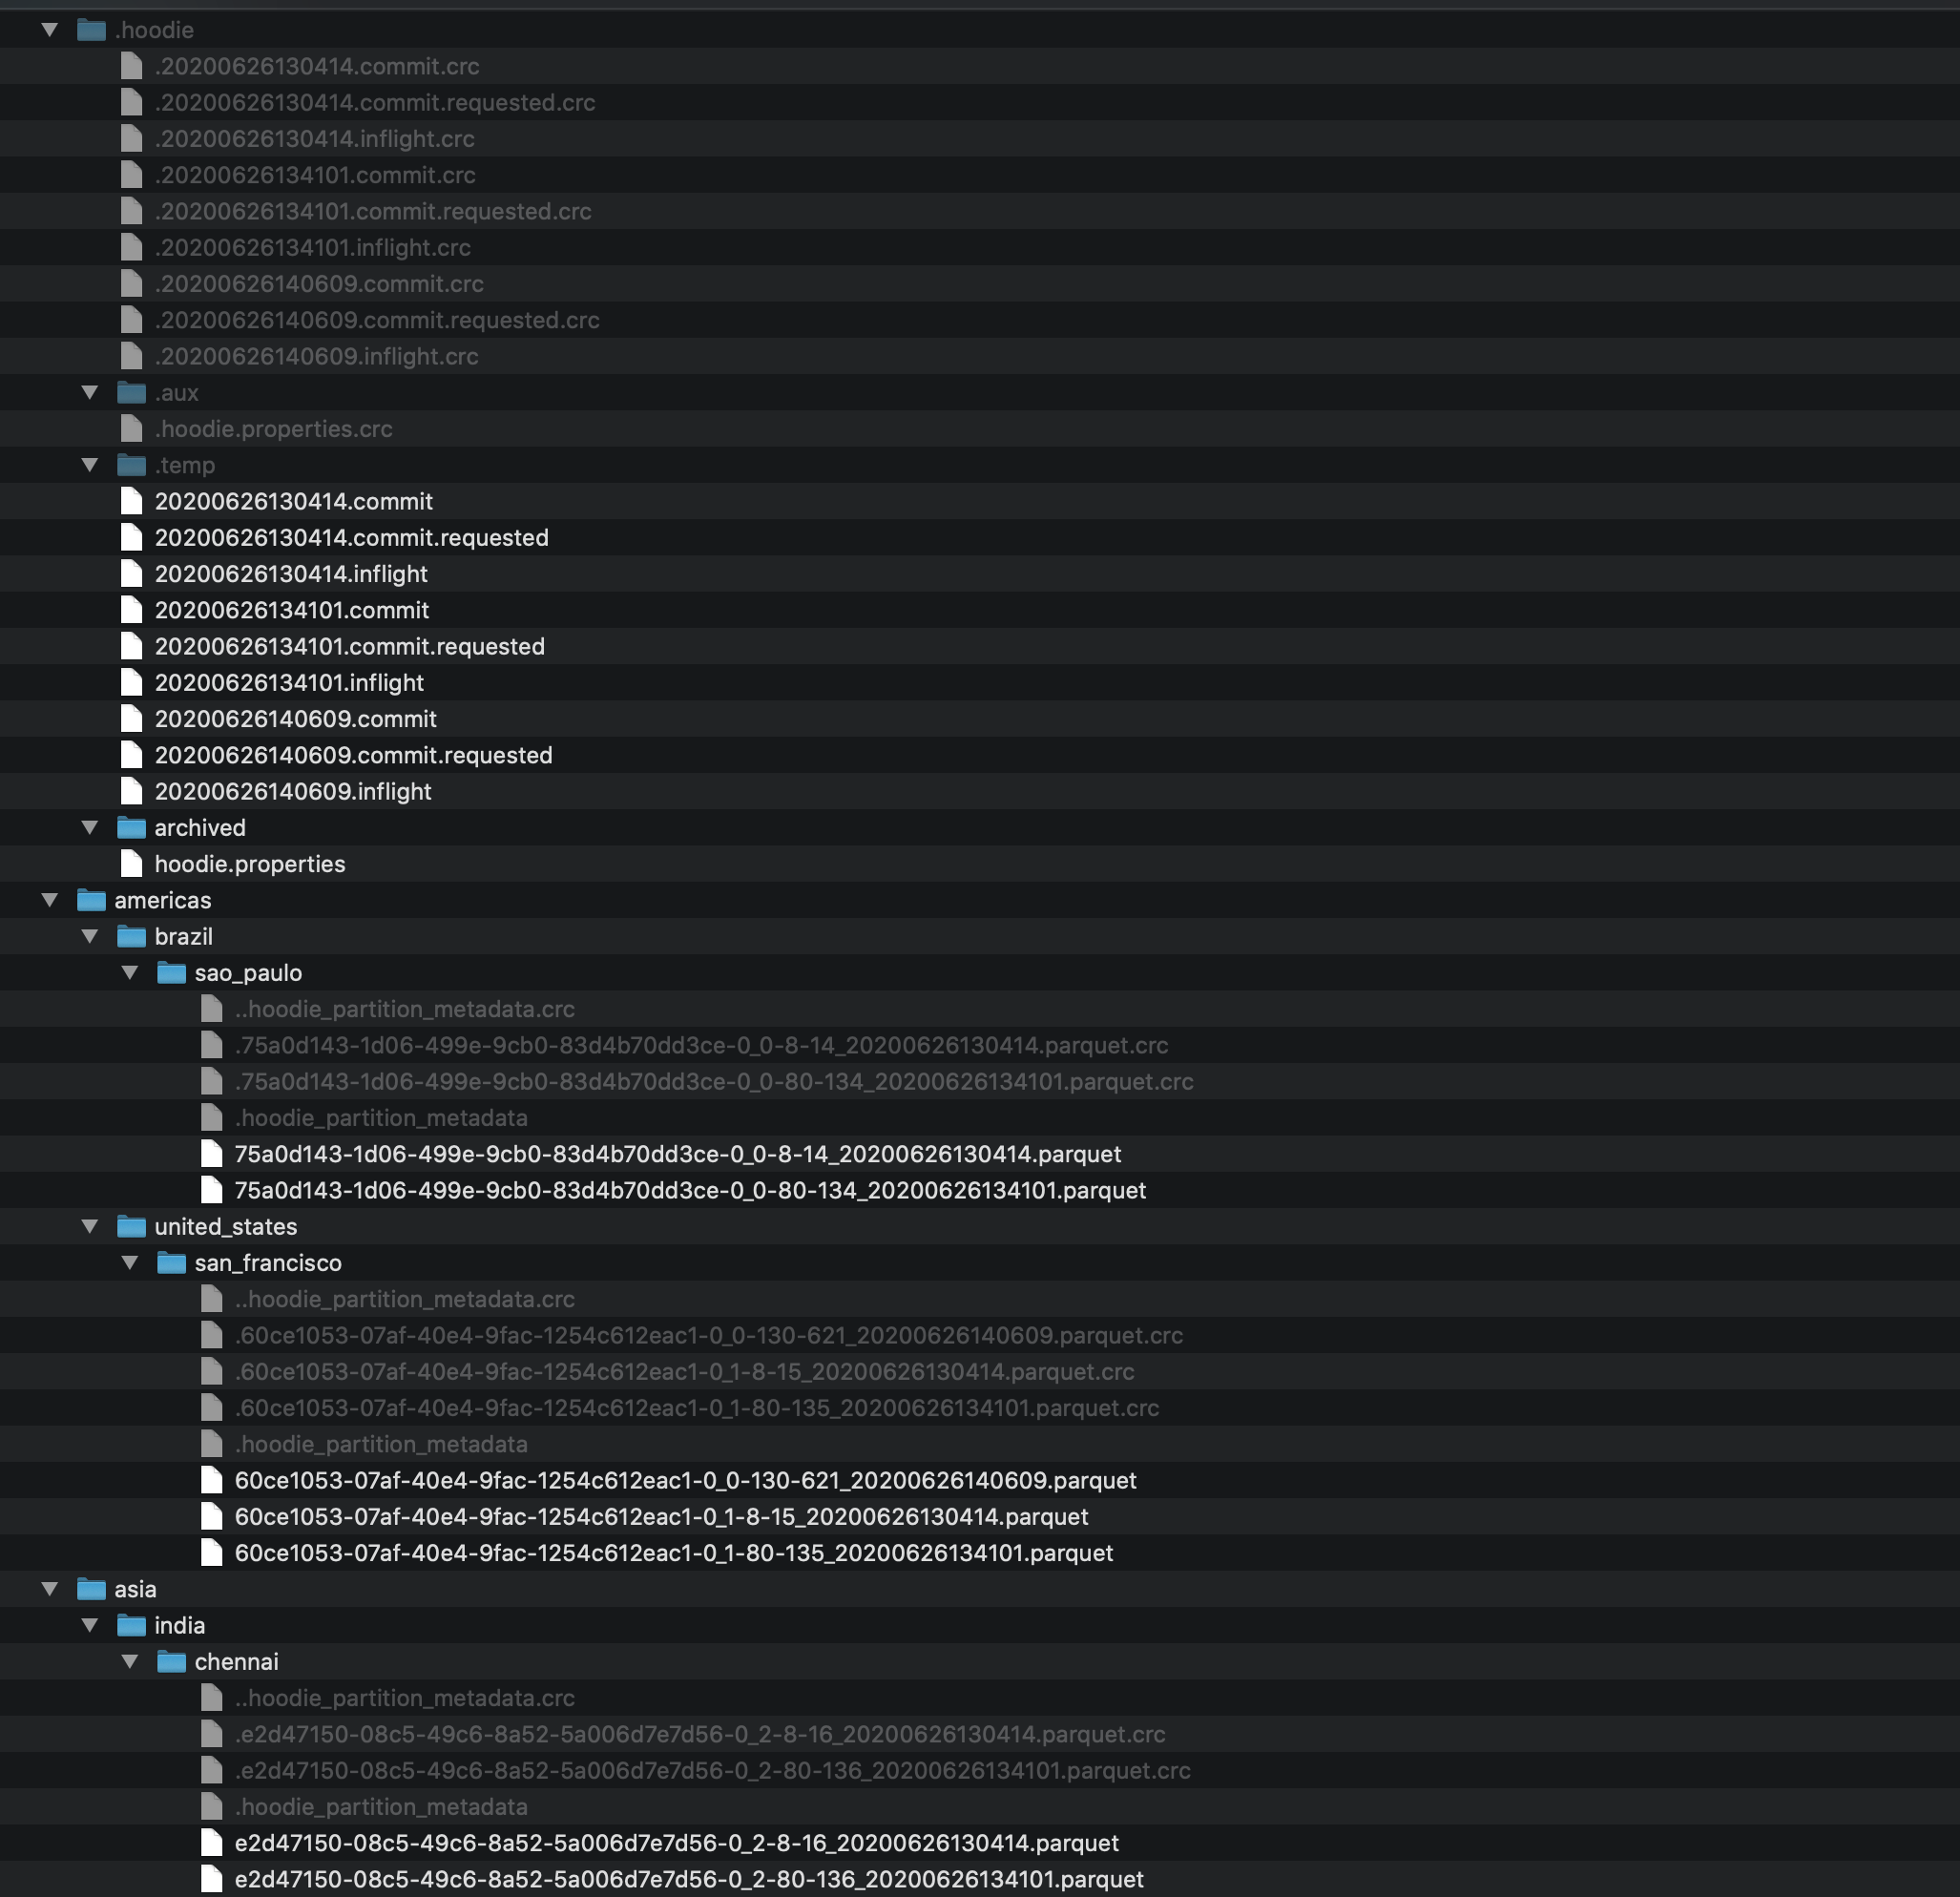
